### Import libraries

In [1]:
from imports import * 
import settings
settings.init()

from basic_text_preprocessing import *
from subject_verb_object_detection import *
from sentence_type_classification import *
from intent_verb_object_extraction import *
from domain_helpers import *
from similar_verbs_replacement import *
from formatted_intents_generation import *
from complaint_queries_identification import *
from results_summarization import *

%matplotlib inline
color = sns.color_palette()

### Load Required datasets

In [2]:
##load corpus

df = pd.read_csv('/Users/avaamo/Desktop/Office_stuff/Bot_Domains/pepboys/pepboys_customer_queries.csv')
#df = df.rename(columns = {'User Query':'user_query'})
#df['user_query'] = df['user_query'].apply(lambda x: str(x))
#df = df[df['Intent'].notnull()]

##load common_phrase_replacements
df_common_phrases = pd.read_csv('/Users/avaamo/Desktop/Office_stuff/Intent_extraction/common_phrases_replacements_file.csv')

##load domain_nouns_verbs_replacements
df_nouns_verbs = pd.read_csv('/Users/avaamo/Desktop/Office_stuff/Intent_extraction/domain_verbs_nouns_replacements_file.csv')

##load domain_entities_grouping
#entities_path = r'/Users/avaamo/Desktop/Office_stuff/Bot_Domains/pepboys/pepboys_Entities'

### Text preprocessing

In [3]:
df['text'] = df['user_query'].apply(lambda x: replace_text_file(x,df_common_phrases))
#df['text'] = df['text'].apply(lambda x: bigrammize_entities(x,entities_path))
#df['text'] = df['text'].apply(lambda x: standardize_text(x))
df['text'] = df['text'].apply(lambda x: ''.join(x))

unigrams_lookup, bigrams_lookup = uni_bigrams_lookup(df)

df['text'] = df['text'].apply(lambda x: replace_with_bigrams(x,unigrams_lookup,bigrams_lookup))
df = replace_with_coreference(df)

### Intent Extraction

In [4]:
sentences_list = []
svo_list = []
sentence_type_list = []
for doc in settings.nlp.pipe(df['text'].astype('unicode').values, batch_size=1000, n_threads=8): 
    sentences1 = list(doc.sents)
    svo1 = [svo(sent) for sent in doc.sents]
    sentence_type1 = [sentence_type(sent) for sent in sentences1]
    sentences_list.append(sentences1)
    svo_list.append(svo1)
    sentence_type_list.append(sentence_type1)
    
df['sentences'] = sentences_list
df['svo'] = svo_list
df['sentence_type'] = sentence_type_list

In [5]:
df['imperative_intents'] = df.apply(lambda row: imperative_intents(row['sentence_type'], row['svo']), axis=1)
df['question_intents'] = df.apply(lambda row: question_intents(row['sentence_type'], row['svo']), axis=1)
df['flat_sentence_type'] = df['sentence_type'].apply(lambda x:[item for sublist in x for item in sublist])
df['query_type'] = df['flat_sentence_type'].apply(lambda x: query_type(x))
df['sentence_category'] = df['sentence_type'].apply(lambda x: sentence_category(x))
df['key_sentence'] = df.apply(lambda row: key_sentence(row['sentences'], row['sentence_category'],row['query_type']), axis=1)
df['intents'] = np.where(df['query_type']=='imperative', df['imperative_intents'], df['question_intents'])
df['declaration_intents'] = df.apply(lambda row: declaration_intents(row['sentences'], row['svo'],row['query_type']), axis=1)
df['intents'] = np.where(df['query_type'] =='declarative', df['declaration_intents'], df['intents'])

### Grouping intents & entities

In [6]:
df['verb'] = df['intents'].apply(lambda x: x[0].split()[0] if len(x) > 0 else None)
df['obj'] = df['intents'].apply(lambda x: x[0].split()[1] if len(x) > 0 else None)
df['intent_element'] = df['intents'].apply(lambda x: x[0] if len(x) > 0 else None)

nouns_verbs_replacement_dict = df_nouns_verbs.set_index('find')['replace'].to_dict()
#entity_grp_dict = gen_entity_dictionary(entities_path)
similar_verbs_replacement_dict = gen_similar_verbs_dictionary(df)

## Replace from manual_file

df['verb1'] = df['verb'].map(nouns_verbs_replacement_dict).fillna(df['verb'])
df['obj1'] = df['obj'].map(nouns_verbs_replacement_dict).fillna(df['obj'])

## Replace from entity group
#df['obj1'] = df['obj1'].map(entity_grp_dict).fillna(df['obj'])


## replace similar verbs with most common verb
df['verb1'] = df['verb1'].map(similar_verbs_replacement_dict).fillna(df['verb'])

df['intent_element1'] = df['verb1'].fillna(df['obj1']) + ' '+ df['obj1'].fillna(df['verb1'])

### Generate meaningful direct intent sentences

In [7]:
pre_intent_dictionary = gen_pre_intent_dictionary(df)
df['final_pre_intent'] = df['intent_element1'].map(pre_intent_dictionary).fillna('')

formatting_dict = gen_formatting_dictionary(df)
df['intent_with_desc'] = df.apply(lambda row: formatting_intent(row['final_pre_intent'], row['intent_element1'],formatting_dict), axis=1)

### Tag complaint intents

In [12]:
df['sentiment'] = df['sentences'].apply(lambda x: [TextBlob(''.join(token.string for token in sent)).sentiment[0] for sent in x])
df['min_sentiment'] = df['sentiment'].apply(lambda x: min(x))
df['sentiment_sentence'] = df.apply(lambda row: sentiment_sentence(row['sentences'], row['sentiment'],row['min_sentiment']), axis=1)
df['sentiment_sentence_type'] = df.apply(lambda row: sentiment_sentence_type(row['sentence_category'], row['sentiment'],row['min_sentiment']), axis=1)
df['complaint_intent_flag'] = df.apply(lambda row: complaint_intent_flag(row['sentiment_sentence_type'], row['intent_element1'],row['min_sentiment']), axis=1)

### Summarization of Results

In [14]:
## Overall Summary

df_summary = overall_summary(df)
df_summary

,Summary,Count of queries,% of queries
0,Total Queries,64404,100.000000
1,Complaints,964,1.496801
2,Direct Intents,36308,56.375380
3,Junk_Queries,5074,7.878393


<module 'seaborn' from '/Users/avaamo/anaconda3/lib/python3.6/site-packages/seaborn/__init__.py'>

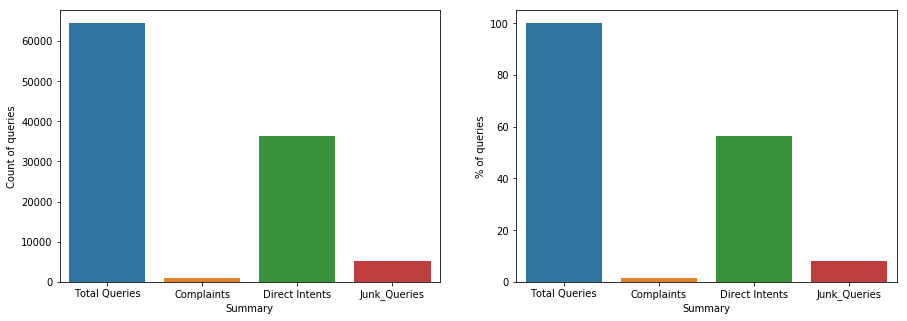

In [15]:
plot_overall_summary(df_summary)

In [21]:
unwanted_objs = ['-PRON-','this','that']
df1 = df[~df['obj1'].isin(unwanted_objs)]
df1 = df1[df1.obj1.notnull()]

df_intents = intents_summary(df1)
df_intents_queries_summary = intents_queries_summary(df_intents)
df_intents_queries_summary

,Summary,Count of intents,Count of queries,% of queries
0,Intents,8581,34101,1.000000
1,80% Intents,2300,27280,0.799977
2,5+ Intents,807,22760,0.667429
3,Top 25 Intents,25,7498,0.219876


<module 'seaborn' from '/Users/avaamo/anaconda3/lib/python3.6/site-packages/seaborn/__init__.py'>

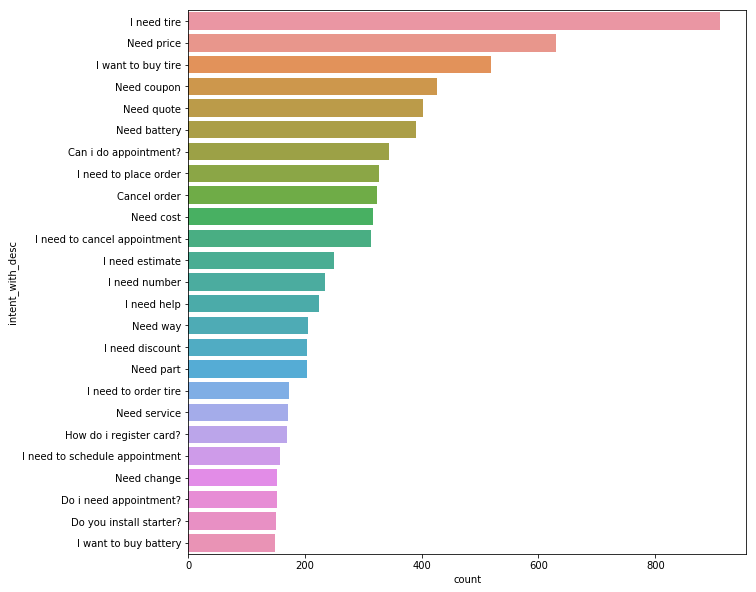

In [22]:
plot_top25_intents(df1)

In [27]:
df_bus_objs = df1.groupby(['obj1']).size().reset_index(name = 'count').sort_values('count',ascending = False)
df_bus_objs_top5 = df_bus_objs.head(5)

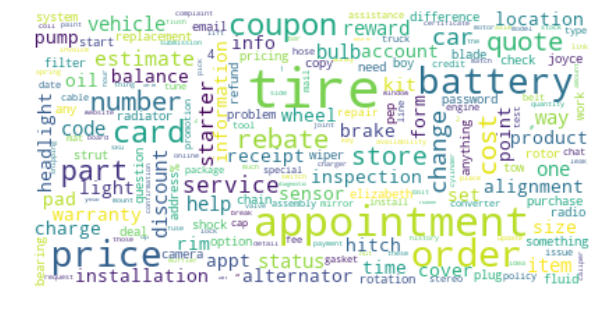

<module 'matplotlib.pyplot' from '/Users/avaamo/anaconda3/lib/python3.6/site-packages/matplotlib/pyplot.py'>

In [24]:
generate_wordcloud(df_bus_objs)

In [28]:
df_bus_objs_top5

,obj1,count
2645,tire,2487
463,appointment,1305
1869,order,1061
572,battery,946
2042,price,940


In [29]:
# 
df_top3_things = pd.merge(df1,df_bus_objs_top5,how = 'inner')
df_top3_things = df_top3_things.groupby(['obj1','intent_with_desc']).size().reset_index(name = 'count').sort_values(['obj1','count'],ascending = False).groupby('obj1').head(3)
df_top3_things

,obj1,intent_with_desc,count
317,tire,I need tire,910
332,tire,I want to buy tire,519
320,tire,I need to order tire,172
241,price,Need price,630
235,price,I would like to know price,91
217,price,Do you match price?,30
162,order,I need to place order,327
134,order,Cancel order,324
157,order,I need order,86
104,battery,Need battery,390


In [42]:
# output_files

df.to_csv('/Users/avaamo/Desktop/job_complete_file.csv')
df_summary.to_csv('/Users/avaamo/Desktop/job_results_summary_file.csv')
df[df.complaint_intent_flag == 1][['user_query','sentiment_sentence']].to_csv('/Users/avaamo/Desktop/job_complaints_file.csv')
df1[['intent_with_desc','user_query','key_sentence']].to_csv('/Users/avaamo/Desktop/job_intents_file.csv')
df_intents[['intent_with_desc','count']].to_csv('/Users/avaamo/Desktop/job_intents_summary_file.csv')
df_bus_objs.to_csv('/Users/avaamo/Desktop/job_bobjs_summary_file.csv')